In [6]:
"""
Performs basic matched filter test by FFT-correlating a measured signal with an input signal/filter 
"""
# import modules we'll need 
import numpy as np
import scipy.fftpack as fftp
from scipy import ndimage
import cv2
import matplotlib.pylab as plt

In [79]:
!pip install imutils

In [80]:
import imutils

In [2]:
##
## Basic steps of matched filtering process
## 
def matchedFilter(
  dimg, # imgs wherein signal (filter) is hypothesized to exist
  daFilter,# signal 
  parsevals=False,
  demean=True
  ):

  ### Check to see if the image is 2D or 3D. cv2 algorithm is a bit quicker for 2D but it\
      #is not compatible with 3D images
  if len(np.shape(dimg)) == 3:
    if isinstance(daFilter, list):
      # this indicates that we've decomposed the filter for sequential filtering
      h = sequential_filtering(dimg, daFilter)
    
    else:
      # Use scipy ndimage routine to convolve the 3D image and Filter
      h = ndimage.convolve(dimg,daFilter)#,mode='mirror')
  else:
    useCV2 = True
    if useCV2:
      if isinstance(daFilter, list):
        # this indicates that we've decomposed the filter for sequential filtering
        h = sequential_filtering(dimg, daFilter)

      else:
        h = cv2.filter2D(dimg,-1,daFilter)

    else:
      # placeholder for 'noise' component (will refine later)
      fsC = np.ones(np.shape(dimg))

      ## prepare img
      # demean/shift img
      if demean:
        sdimg = fftp.fftshift(dimg - np.mean(dimg))
      else:
        sdimg = fftp.fftshift(dimg)
      # take FFT 
      fsdimg = fftp.fft2(sdimg)

        ## zero-pad filter
      si = np.shape(dimg)
      sf = np.shape(daFilter)
      # add zeros
      zeropad = np.zeros(si)
      zeropad[:sf[0],:sf[1]]=daFilter
      # shift original ligand by its Nyquist
      szeropad = np.roll(\
        np.roll(zeropad,-sf[0]/2+si[0]/2,axis=0),-sf[1]/2+si[1]/2,axis=1)
      f= szeropad

      ## signal
      # shift,demean filter
      if demean:
        sfilter = fftp.fftshift(f- np.mean(f))
      else:
        sfilter = fftp.fftshift(f)
      # take FFT
      fsfilter= fftp.fft2(sfilter)

      ## matched filter
      fsh = fsdimg * fsfilter / fsC
      #fsh = np.real( fsh ) 
      sh = fftp.ifft2(fsh)
      h = fftp.ifftshift(sh)
      h = np.real(h)

      ## apply parsevals
      if parsevals:
        h *= 1/np.float(np.prod(np.shape(h)))
  return h 


In [48]:
def add_gaussian_noise(image,var=0.1,mean=0.0):
    """
    add gaussian noise to image
    """
    dimes = image.shape
    mean = mean
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,dimes)
    #gauss = gauss.reshape(dimes)
    noisy = image + gauss
    return noisy

In [3]:
def sequential_filtering(dimg,daFilter_list):
  '''Function to perform sequential filtering of 'dimg' given a list of filters.
  This is advantageous since there is a massive speedup for large 2D or 3D filters that can be 
  linearly decomposed.'''

  # loop through the filters and sequentially apply them
  # for (axis, filt) in iteritems(daFilter_dict):
  #   # check if it's a one-dimensional filter
  #   if isinstance(axis, int):
  #     dimg = ndimage.convolve1d(dimg, filt, axis=axis)
    
  #   elif isinstance(axis, str):
  #     dimg = ndimage.convolve(dimg, filt)
  for filt in daFilter_list:
    dimg = ndimage.convolve(dimg, filt)
    
  return dimg

In [99]:
def construct_test_image(filternames,perct=None, nRows=10,nCols=50):
    '''
    construct a test image (size = nRows x nCols all_signals) using filternames (a list containts the name)
    and the percentage of each filter
    '''
    filter_dimes = np.shape(all_signals[filternames[0]])
    image_size_x = filter_dimes[0]*nRows
    image_size_y = filter_dimes[1]*nCols
    
    test_image = np.ones((image_size_x,image_size_y))
    
    
    numall_signals = len(filternames) # the number of all_signals
    
    for m in np.arange(nRows):
        for n in np.arange(nCols):
            prob = np.random.rand()
            for j in np.arange(numall_signals):
                    if j == 0:
                        left = 0
                    else: 
                        left = np.sum(perct[0:j])
                    right = left + perct[j]
                    if prob >= left and prob <= right:
                        indx = j

            test_image[m*filter_dimes[0]:(m+1)*filter_dimes[0],\
                        n*filter_dimes[1]:(n+1)*filter_dimes[1]] = all_signals[filternames[indx]]
            
    # now add some gaussian noise
    test_image = add_gaussian_noise(test_image,var=100)
       
    return test_image

In [93]:
# load in the signal (cell)
signal = cv2.imread('signal.png',0) #read in as gray-scale
signal = 255 - signal # invert the white/black so that cell body is white and background is black

# construct a test image using the singal with some gassuain noise added
testimage = add_gaussian_noise(signal,var=100,mean=50)

noise = testimage - signal

Text(0.5, 1.0, 'signal + noise')

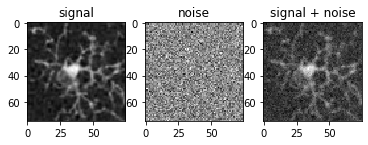

In [50]:
plt.subplot(1,3,1)
plt.imshow(signal,cmap='gray')
plt.title('signal')
plt.subplot(1,3,2)
plt.imshow(noise,cmap='gray')
plt.title('noise')
plt.subplot(1,3,3)
plt.imshow(testimage,cmap='gray')
plt.title('signal + noise')

In [55]:
#Now try the match filter method
# The filter is essentially the signal, but as a filter (kernal), we usually
# need to make sure that the sum of all piexl intensity is 1

Filter = signal/np.sum(signal)

In [63]:
# Now try the match filter using the test image
testimage_response = matchedFilter(testimage,Filter)
noise_response = matchedFilter(noise,Filter)

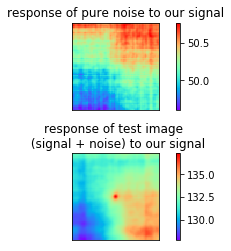

In [118]:
vmax = np.max([np.max(noise_response),np.max(testimage_response)])
plt.subplot(2,1,1)
plt.imshow(noise_response,cmap='rainbow')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('response of pure noise to our signal')
plt.subplot(2,1,2)
plt.imshow(testimage_response,cmap='rainbow')
plt.title('response of test image \n (signal + noise) to our signal')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.subplots_adjust(hspace=0.5)

In [84]:
# now construct a big test image using the signal and its rotated version
r90_signal = imutils.rotate(signal,90)
all_signals = {
    'signal':signal,
    'r90_signal':r90_signal
}

In [100]:
big_testImage1=construct_test_image(['signal'],[1],nRows=5,nCols=4) # using all nornal signals to construct the big test image
big_testImage2=construct_test_image(['signal','r90_signal'],[0.8,0.2],nRows=5,nCols=4) # using 80% nornal signals and 20% rotated signals 

([], <a list of 0 Text yticklabel objects>)

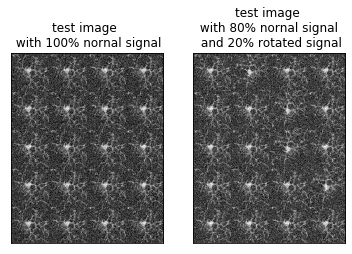

In [119]:
plt.subplot(1,2,1)
plt.imshow(big_testImage1,cmap='gray')
plt.title('test image \n with 100% nornal signal')
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(big_testImage2,cmap='gray')
plt.title("test image \n with 80% nornal signal \n and 20% rotated signal")
plt.xticks([])
plt.yticks([])

In [114]:
# check the reponse 
bigImage1_response = matchedFilter(big_testImage1,Filter)
bigImage2_response = matchedFilter(big_testImage2,Filter)

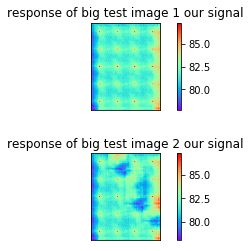

In [121]:
plt.subplot(2,1,1)
plt.imshow(bigImage1_response,cmap='rainbow')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('response of big test image 1 our signal')
plt.subplot(2,1,2)
plt.imshow(bigImage2_response,cmap='rainbow')
plt.title('response of big test image 2 our signal')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.subplots_adjust(hspace=0.5)